# Set up data connection and load data

In [1]:
import os
import json
import timeit
import pandas as pd
from math import ceil
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report 
import xgboost as xgb 
import matplotlib.pyplot as plt
import snowflake.connector
print("snowflake connector version = " + snowflake.connector.__version__)

snowflake connector version = 2.6.0


In [2]:
# Read credentials json file from ~/creds/creds.json 
creds_folder = os.path.expanduser('~/creds')
creds_file = creds_folder + "/creds.json"

# Set LDAP password, warehouse values
with open(creds_file) as file:
    data = json.load(file)
    ldap_userid = data["ldap_userid"]
    ldap_password = data["ldap_password"]
    warehouse_name = data["warehouse_name"]

# set DB parameters
role_id = "ROLE_" + str(ldap_userid)
database_name = "SFAAP"
schema_name = "PUBLIC"

In [3]:
# start time
t_start = timeit.default_timer()

con = snowflake.connector.connect(
    user=ldap_userid,
    password=ldap_password,
    role=role_id,
    warehouse=warehouse_name,
    database=database_name,
    schema=schema_name,
    authenticator="https://didentity.okta.com",
    account="dfs.us-east-1.privatelink",
)
cursor = con.cursor()

wh_query = "use warehouse " + warehouse_name
results = cursor.execute(wh_query)

sql_query = "SELECT * from WS_DATATHON.DEV_USTPRS21_HACKATHON"
print("sql_query = ", sql_query)
results = cursor.execute(sql_query)
train_df = pd.DataFrame.from_records(iter(results), columns=[x[0] for x in results.description])

sql_query = "SELECT * from WS_DATATHON.VAL_USTPRS21_HACKATHON"
print("sql_query = ", sql_query)
results = cursor.execute(sql_query)
validation_df = pd.DataFrame.from_records(iter(results), columns=[x[0] for x in results.description])

sql_query = "SELECT * from WS_DATATHON.OOT_JAN21_USTPRS21_HACKATHON"
print("sql_query = ", sql_query)
results = cursor.execute(sql_query)
test_df = pd.DataFrame.from_records(iter(results), columns=[x[0] for x in results.description])

con.close()

t_stop = timeit.default_timer()
print("Query completed, Time taken(mins):", round((t_stop - t_start) / 60, 2))

sql_query =  SELECT * from WS_DATATHON.DEV_USTPRS21_HACKATHON
sql_query =  SELECT * from WS_DATATHON.VAL_USTPRS21_HACKATHON
sql_query =  SELECT * from WS_DATATHON.OOT_JAN21_USTPRS21_HACKATHON
Query completed, Time taken(mins): 18.87


In [4]:
train_df = train_df.drop(['PERF_MTHLY_DT', 'CIMS_ACCT_KEY'], axis=1)
validation_df = validation_df.drop(['PERF_MTHLY_DT', 'CIMS_ACCT_KEY'], axis=1)
test_df = test_df.drop(['PERF_MTHLY_DT', 'CIMS_ACCT_KEY'], axis=1)
train_df.head()

,BAL_TO_CLMT_UTIL_H1,NONBT_TO_CLMT_UTIL_H1,CPYMT_TO_MIN_RATIO_AVG03M,CDLQNT_CYCL_CNT_MSN12M,CPYMT_TO_MIN_RATIO_H1,TBCC1301,NBT_RVLR_TO_CLMT_UTIL_CMX12M,CDLQNT_CYCL_CNT_MAX03M,TBCA0456,NBT_RVLR_TO_CLMT_UTIL_CMX03M,...,CNONBT_BAL_A_TND06M,DEPSTR_AMT_AVG12M,CTOT_BAL_A_CAV03M,WALLET_SHARE_AVG06M,AMAZON_SALES_CNT_MCD06M,CTOT_INT_BAL_A_MAI06M,CTOT_MC_SLS_ACT_OR_C_CMX06M,SERVICES_SALES_AMT_CAV06M,CTOT_RWRD_EARN_MSN03M,BAD
0,0.000000,0.000000,20.950000,12.0,20.950000,14.0,0.0,0.0,NaN,0.0,...,0.000,0.000000,0.000000,0.000248,0.0,0.0,0.200000,0.000000,0.0,0.0
1,0.007516,0.007516,25.619048,12.0,29.714286,0.0,0.0,0.0,NaN,0.0,...,15.784,5.458333,0.547118,0.391386,1.0,0.0,0.967742,0.935578,0.0,0.0
2,0.026848,0.026848,11.918857,12.0,12.420857,5.0,0.0,0.0,NaN,0.0,...,-104.026,21.392500,0.723804,1.000000,0.0,0.0,0.421053,0.000000,0.0,0.0
3,0.000000,0.000000,NaN,12.0,NaN,0.0,0.0,0.0,NaN,0.0,...,0.000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,NaN,0.0
4,0.000000,0.000000,NaN,12.0,NaN,6.0,0.0,0.0,NaN,0.0,...,0.000,0.000000,0.000000,0.004762,1.0,0.0,0.000000,0.000000,NaN,0.0


<AxesSubplot:>

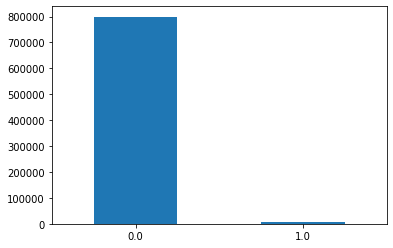

In [11]:
train_df['BAD'].value_counts().plot.bar(rot=0)

In [12]:
# chech categorical vs numeric columns 
num_cols = train_df._get_numeric_data().columns
cat_cols = train_df.columns
print("Number of numeric: ", len(num_cols), "\nCategorical cols: ", list(set(cat_cols) - set(num_cols)))

Number of numeric:  1438 
Categorical cols:  []


# Preprocess data

In [13]:
# fill Nan and standardized
def process_data(data_df): 
    data_y = data_df['BAD']
    data_x = data_df.drop(['BAD'], axis=1).fillna(0)
    standard_x = pd.DataFrame(preprocessing.scale(data_x), columns=data_x.columns)
    return standard_x, data_y

In [7]:
train_x, train_y = process_data(train_df)
validation_x, validation_y = process_data(validation_df)
test_x, test_y = process_data(test_df)

# Build model and check performance on validation set

In [8]:
#build model
dtrain = xgb.DMatrix(train_x, label=train_y)

param = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'binary:logistic',
}
num_round = 30  # tree number

model = xgb.train(params=param, dtrain=dtrain, num_boost_round=num_round)

[05:50:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [9]:
#predict on validation dataset
validation_y_pred = model.predict(xgb.DMatrix(validation_x, label=None))
fpr, tpr, thresholds = roc_curve(validation_y, validation_y_pred) 
print('Validation AUC: ', auc(fpr, tpr))

Validation AUC:  0.8829224251063743


In [10]:
#compare with training dataset
train_y_pred = model.predict(xgb.DMatrix(train_x, label=None))
fpr, tpr, thresholds = roc_curve(train_y, train_y_pred) 
print('Training AUC: ', auc(fpr, tpr))

Training AUC:  0.9335495039700428


In [11]:
# feature importance
feat_importance = sorted(model.get_score(importance_type='weight').items(), key=lambda x: x[1], reverse=True)
print(feat_importance[:5])

[('SOURCECREDHEADERTIMEOLDEST', 28.0), ('TBCA0456', 25.0), ('CDLQNT_CYCL_CNT_MSN12M', 23.0), ('TBCC4303', 16.0), ('TBCA2527', 16.0)]


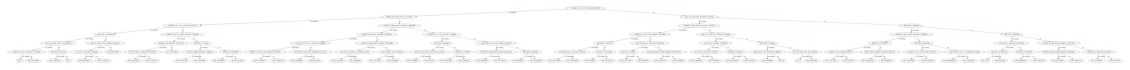

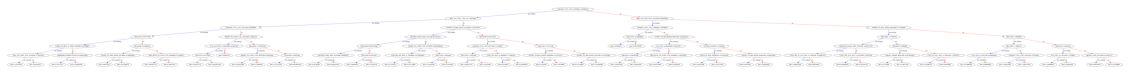

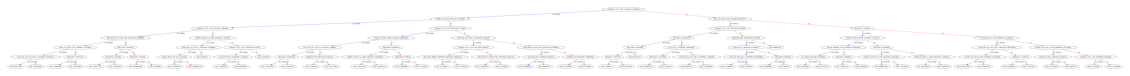

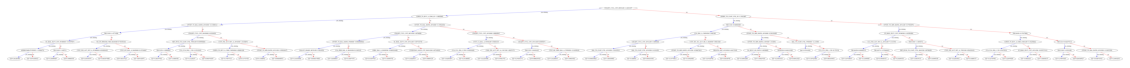

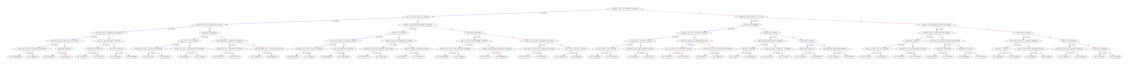

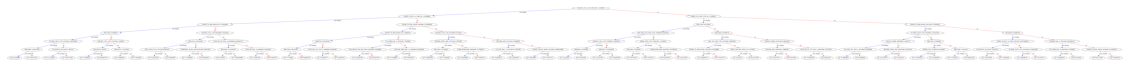

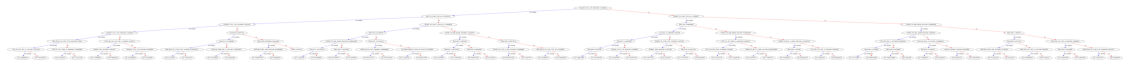

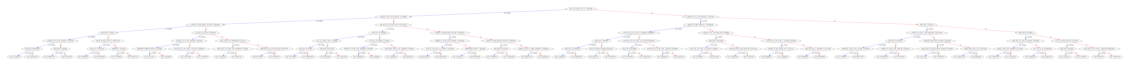

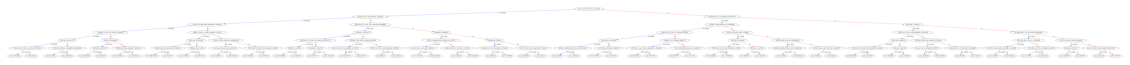

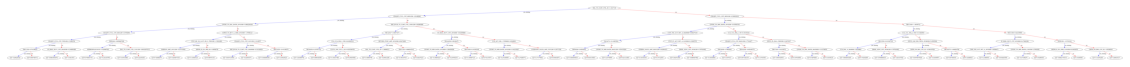

In [20]:
# tree structure
for i in range(num_round):
    xgb.plot_tree(model, num_trees=i)
    fig = plt.gcf()
    fig.set_size_inches(20, 15)
    fig.savefig('tree_{}.png'.format(i))

# Get final output on testing dataset

In [13]:
#predict on testing dataset
test_y_pred = model.predict(xgb.DMatrix(test_x, label=None))
fpr, tpr, thresholds = roc_curve(test_y, test_y_pred)
print('Validation AUC: ', auc(fpr, tpr))

Validation AUC:  0.8754357552968579


In [37]:
#generate gain chart
group_size = ceil(len(test_y) / 10)
output = pd.DataFrame({'pred':list(test_y_pred), 'y':list(test_y)}).sort_values(by=['pred'], ascending=False).reset_index()
output['group'] = output.index // group_size

In [83]:
gain_chart = pd.DataFrame({'Rank':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})
gain_chart['# of Accounts'] = output.groupby('group').size()
gain_chart['Min_Score'] = output[['pred', 'group']].groupby('group').min()
gain_chart['Max_Score'] = output[['pred', 'group']].groupby('group').max()
gain_chart['Mean_Score'] = output[['pred', 'group']].groupby('group').mean()
gain_chart['# of Bad'] = output[['y', 'group']].groupby('group').sum().astype('int64')
gain_chart['Actual Bad Rate'] = gain_chart['# of Bad'] / gain_chart['# of Accounts']
gain_chart['Bad Capture Rate by Rank'] = gain_chart['# of Bad'] / output['y'].sum()
gain_chart['Cumulative Bad Capture Rate'] = gain_chart['# of Bad'].cumsum() / output['y'].sum()

In [84]:
gain_chart

,Rank,# of Accounts,Min_Score,Max_Score,Mean_Score,# of Bad,Actual Bad Rate,Bad Capture Rate by Rank,Cumulative Bad Capture Rate
0,1,58048,0.020963,0.956056,0.068650,3291,0.056694,0.628894,0.628894
1,2,58048,0.009797,0.020963,0.014244,852,0.014678,0.162813,0.791706
2,3,58048,0.005804,0.009797,0.007526,387,0.006667,0.073954,0.865660
3,4,58048,0.003920,0.005804,0.004765,280,0.004824,0.053507,0.919167
4,5,58048,0.002897,0.003920,0.003361,146,0.002515,0.027900,0.947067
5,6,58048,0.002262,0.002897,0.002558,82,0.001413,0.015670,0.962736
6,7,58048,0.001799,0.002262,0.002023,76,0.001309,0.014523,0.977260
7,8,58048,0.001388,0.001799,0.001592,46,0.000792,0.008790,0.986050
8,9,58048,0.000978,0.001388,0.001187,49,0.000844,0.009364,0.995414
9,10,58047,0.000240,0.000978,0.000716,24,0.000413,0.004586,1.000000
